# Conversion rate VS. Time

In [ ]:
pip install pandasql

In [ ]:
pip install plotly

In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import plotly.express as px


## Load Data

In [ ]:
data = pd.read_csv('cover_test_dataset.csv')
data

,user_id,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at
0,197393,2019-10-09 23:58,2019-10-10 0:03,2019-10-10 18:16,NaN
1,197392,2019-10-09 23:57,2019-10-10 0:04,NaN,NaN
2,197391,2019-10-09 23:56,NaN,NaN,NaN
3,197390,2019-10-09 23:56,2019-10-10 0:11,2019-10-10 0:26,NaN
4,197389,2019-10-09 23:56,2019-10-09 23:59,2019-10-10 23:09,NaN
...,...,...,...,...,...
132291,64926,2018-10-10 0:11,NaN,NaN,NaN
132292,64925,2018-10-10 0:10,2018-10-10 0:13,2018-10-10 0:16,NaN
132293,64924,2018-10-10 0:07,2018-10-10 0:07,2018-10-10 0:09,NaN
132294,64923,2018-10-10 0:06,2018-10-10 0:06,2018-10-10 0:11,NaN


In [ ]:
# Change data type 
data.iloc[:,1:]= data.iloc[:,1:].apply(pd.to_datetime)

In [ ]:
data.describe(include='all',datetime_is_numeric =True)

,user_id,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at
count,132296.000000,132290,99058,74394,5741
mean,131166.652952,2019-05-20 14:17:46.873837568,2019-05-21 20:48:27.324597504,2019-04-29 19:11:09.758044928,2019-06-10 16:50:42.379376640
min,64922.000000,2018-10-10 00:01:00,2018-10-09 22:19:00,2018-10-10 00:04:00,2018-10-10 18:24:00
25%,98046.750000,2019-02-13 02:37:15,2019-02-16 07:07:30,2019-01-15 02:29:30,2019-03-19 15:25:00
50%,131156.500000,2019-06-24 14:40:00,2019-06-24 04:08:30,2019-05-13 22:11:00,2019-07-18 23:47:00
75%,164286.250000,2019-08-28 21:00:30,2019-08-28 17:52:15,2019-08-15 21:26:00,2019-09-11 22:15:00
max,197393.000000,2019-10-09 23:58:00,2019-10-18 18:02:00,2019-10-18 18:38:00,2019-10-18 19:13:00
std,38236.338992,NaN,NaN,NaN,NaN


## **Sales Funnel**


In [ ]:
# gettin not null values 
a= len(data)- data.isnull().sum()
a

user_id                           132296
installation_at                   132290
request_created_at                 99058
agent_responded_to_customer_at     74394
customer_sold_at                    5741
dtype: int64

In [ ]:
from plotly import graph_objects as go
fig = go.Figure(go.Funnel(
    y = ['Users','Installation', 'Requested', 'Agent_responded', 'Customer_sold'],
    x = np.round(a[:],2),
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65)
    )

fig.show()

The funnel charts showed multiple conversion rates along the user journey. We can find the bottleneck, aka, where the customers are lost. 

As we can perfom a bottleneck-research from the graph above, we can see that 

- Installation 

    ↓   74.9%

- Requested 

    ↓  75.1%  

- Responded 

    ↓ 7.7% 
- Sold 

The data tells us that during the time period when the data was collected, 75% of users requested price, and our agent has reached out to 75% of them, but only 7.7% of them are successfully converted. 
- This means thE most of the customer lost happend AFTER customer submited their informatiom. There are some directions that we can look into:
   1. **how many customers comfirmed their interested in the price**?  
   we would record one more step (customers_interested); if most of the customer lost happend here, then the cause might be the price being too high or policy are not what they are looking for. 
   2. **how long is the wait time in the queue?**
   There is a high chance of losing costomer if we let them wait for too long. Reduce the wait time if this is the root cuase. 
   3. **agent's stratgy when speaking to customer.**

   How do we contact our customers? by phone? by email? 

   When are we contacting our customer? morning? night? weekdays?weenkends? 


There is also other areas we would look into:
- 
when customer installed the app, it's easy for them to navigate thru the app and knowing how to submit their information? 



### How does wait time in the queue effect customer conversion?

In [ ]:
data1 = data.copy()

In [ ]:
data1['wait_time'] = (data1['agent_responded_to_customer_at'] - data1['request_created_at']).dt.total_seconds()/60
data1.describe()

,user_id,wait_time
count,132296.000000,74232.000000
mean,131166.652952,1866.719393
std,38236.338992,10607.430996
min,64922.000000,-283698.000000
25%,98046.750000,3.000000
50%,131156.500000,25.000000
75%,164286.250000,936.000000
max,197393.000000,525642.000000


#### Distribution

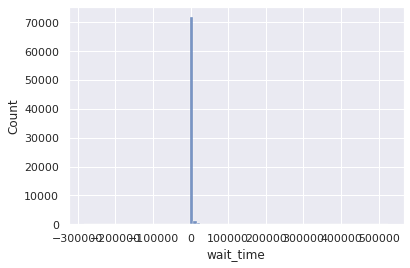

In [ ]:
sns.set()
sns.histplot(data=data1, x='wait_time', bins= 100)

In [ ]:
q = """
    SELECT user_id, agent_responded_to_customer_at,request_created_at,wait_time
    FROM data1
    WHERE wait_time IS NULL OR wait_time <= 0 
    ORDER BY wait_time
"""
t=ps.sqldf(q, locals())

In [ ]:
q = """
    SELECT SUM(CASE WHEN wait_time >0.00 THEN 1 ELSE 0 END) AS pos_time,
           SUM(CASE WHEN wait_time <0.00 THEN 1 ELSE 0 END) AS nag_time,
           SUM(CASE WHEN wait_time =0.00 THEN 1 ELSE 0 END) AS immi_res,
           SUM(CASE WHEN wait_time IS NULL THEN 1 ELSE 0 END ) AS na
    FROM data1
"""
w = ps.sqldf(q, locals())

In [ ]:
pec=pd.DataFrame(w/len(data1)*100)
pec

,pos_time,nag_time,immi_res,na
0,54.174729,0.043085,1.892725,43.88946


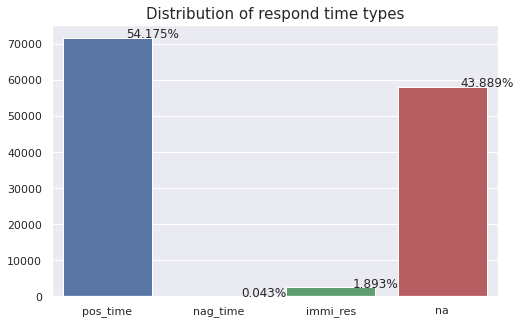

In [ ]:
plt.figure(figsize=(8,5))

ax = sns.barplot(data=w, capsize=.2)
plt.title('Distribution of respond time types', fontsize=15)

for p in ax.patches:
    percentage = '{:.3f}%'.format(100 * p.get_height()/len(data1))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

There are 0.043% of the responds time are nagative, those might happend due to technique issue, thus we remove them. 

Our agent never responded to 43.89% of the customers because they’ve indicated they’re not interested in the insurance policy

Our immediately respond rate is only 1.9%. 

Majority of the responde rate is still positive. Now let's take a closer look at those time periods.

### Outliers

1. Remove nagetive values
2. Remove NA values

In [ ]:
q = """
    SELECT *
    FROM data1
    WHERE wait_time > 0.0 
"""
w = ps.sqldf(q, locals())

In [ ]:
w['wait_time'].describe()

count     71671.000000
mean       1950.753457
std       10696.448938
min           1.000000
25%           3.000000
50%          38.000000
75%         973.000000
max      525642.000000
Name: wait_time, dtype: float64

In [ ]:
w['wait_time'].mode()

0    1.0
dtype: float64

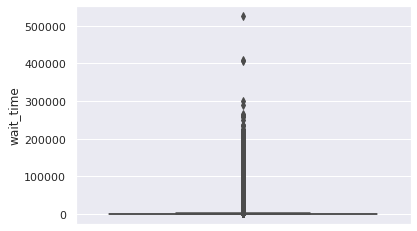

In [ ]:
sns.boxplot(y=w['wait_time'])

our data is extreme skewed, Most data points are at the lower end. I will take the lower 25% as a threshold. 

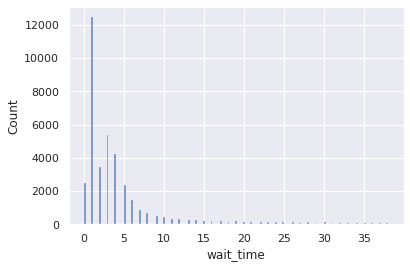

In [ ]:
q = """
    SELECT *
    FROM data1
    WHERE wait_time BETWEEN 0 AND 38
"""
sns.histplot(data=ps.sqldf(q, locals()) , x='wait_time')

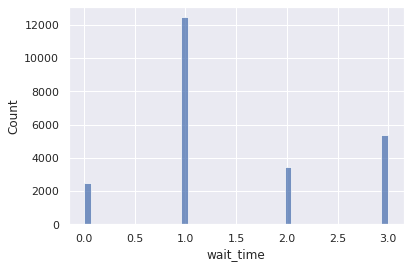

In [ ]:
q = """
    SELECT *
    FROM data1
    WHERE wait_time BETWEEN 0 AND  3 
"""
sns.histplot(data=ps.sqldf(q, locals()) , x='wait_time')

## Multiple Conversion Rate analysis

### 90 days aftrer installation 

In [ ]:
df = data.copy()
df['offset_90'] = df['installation_at'] + pd.DateOffset(days=90)
df['offset_180'] = df['installation_at'] + pd.DateOffset(days=180)
df['offset_270'] = df['installation_at'] + pd.DateOffset(days=270)
df['offset_360'] = df['installation_at'] + pd.DateOffset(days=360)
df.head()

,user_id,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at,offset_90,offset_180,offset_270,offset_360
0,197393,2019-10-09 23:58:00,2019-10-10 00:03:00,2019-10-10 18:16:00,NaT,2020-01-07 23:58:00,2020-04-06 23:58:00,2020-07-05 23:58:00,2020-10-03 23:58:00
1,197392,2019-10-09 23:57:00,2019-10-10 00:04:00,NaT,NaT,2020-01-07 23:57:00,2020-04-06 23:57:00,2020-07-05 23:57:00,2020-10-03 23:57:00
2,197391,2019-10-09 23:56:00,NaT,NaT,NaT,2020-01-07 23:56:00,2020-04-06 23:56:00,2020-07-05 23:56:00,2020-10-03 23:56:00
3,197390,2019-10-09 23:56:00,2019-10-10 00:11:00,2019-10-10 00:26:00,NaT,2020-01-07 23:56:00,2020-04-06 23:56:00,2020-07-05 23:56:00,2020-10-03 23:56:00
4,197389,2019-10-09 23:56:00,2019-10-09 23:59:00,2019-10-10 23:09:00,NaT,2020-01-07 23:56:00,2020-04-06 23:56:00,2020-07-05 23:56:00,2020-10-03 23:56:00


In [ ]:
q = """
    SELECT *
    FROM 
    (SELECT 'Interval_1' AS Days, 
          COUNT(d2.customer_sold_at) AS Sold,
          COUNT(d2.agent_responded_to_customer_at) AS Responded,
          COUNT(d2.request_created_at) AS Requested
    FROM df d1 
    LEFT JOIN df d2 
      ON d1.user_id = d2.user_id 
    WHERE d1.customer_sold_at <= d2.offset_90 
UNION 
 SELECT 'Interval_2' AS Days, 
          COUNT(d2.customer_sold_at) AS Sold,
          COUNT(d2.agent_responded_to_customer_at) AS Responded,
          COUNT(d2.request_created_at) AS Requested
    FROM df d1 
    LEFT JOIN df d2 
      ON d1.user_id = d2.user_id 
    WHERE d1.customer_sold_at BETWEEN d2.offset_90 AND d2.offset_180 
UNION 
 SELECT 'Interval_3' AS Days, 
          COUNT(d2.customer_sold_at) AS Sold,
          COUNT(d2.agent_responded_to_customer_at) AS Responded,
          COUNT(d2.request_created_at) AS Requested
    FROM df d1 
    LEFT JOIN df d2 
      ON d1.user_id = d2.user_id 
    WHERE d1.customer_sold_at BETWEEN d2.offset_180 AND d2.offset_270 
UNION 
 SELECT 'Interval_4' AS Days, 
          COUNT(d2.customer_sold_at) AS Sold,
          COUNT(d2.agent_responded_to_customer_at) AS Responded,
          COUNT(d2.request_created_at) AS Requested
    FROM df d1 
    LEFT JOIN df d2 
      ON d1.user_id = d2.user_id 
    WHERE d1.customer_sold_at BETWEEN d2.offset_270 AND d2.offset_360) T
    ORDER BY Days
 """
t1=ps.sqldf(q, locals())

In [ ]:
t1

,Days,Sold,Responded,Requested
0,Interval_1,5469,5430,5464
1,Interval_2,192,188,192
2,Interval_3,49,49,49
3,Interval_4,29,29,29


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

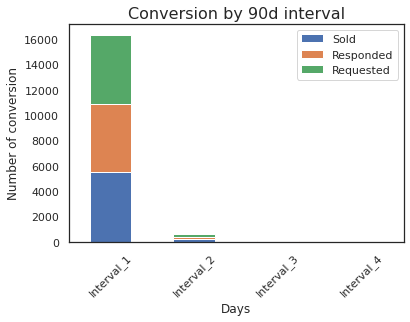

In [ ]:

sns.set(style='white')

#create stacked bar chart
t1.set_index('Days').plot(kind='bar', stacked=True)

#add overall title
plt.title('Conversion by 90d interval', fontsize=16)

#add axis titles
plt.xlabel('Days')
plt.ylabel('Number of conversion')

#rotate x-axis labels
plt.xticks(rotation=45)

In [ ]:
l = t1['Sold']
for i,j in zip(range(1,5),l):
  print('Final Conversion Rate for',i,'th 90d interval is',np.round(j/132290*100,2),'%,','which is',np.round(j/5741*100,2),'% of total Conversed customers')

Final Conversion Rate for 1 th 90d interval is 4.13 %, which is 95.26 % of total Conversed customers
Final Conversion Rate for 2 th 90d interval is 0.15 %, which is 3.34 % of total Conversed customers
Final Conversion Rate for 3 th 90d interval is 0.04 %, which is 0.85 % of total Conversed customers
Final Conversion Rate for 4 th 90d interval is 0.02 %, which is 0.51 % of total Conversed customers


From above, we can see that majority of the conversions happended within the first 90d interval, which means we should try to investe most on engaging with our customer during this time frame. 

### Waitime vs. Converation rate at each step 

In [ ]:
df1 = data.copy()
df1 = df1.set_index('user_id')

In [ ]:
df1.head()

,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at
user_id,,,,
197393,2019-10-09 23:58:00,2019-10-10 00:03:00,2019-10-10 18:16:00,NaT
197392,2019-10-09 23:57:00,2019-10-10 00:04:00,NaT,NaT
197391,2019-10-09 23:56:00,NaT,NaT,NaT
197390,2019-10-09 23:56:00,2019-10-10 00:11:00,2019-10-10 00:26:00,NaT
197389,2019-10-09 23:56:00,2019-10-09 23:59:00,2019-10-10 23:09:00,NaT


In [ ]:
df1['ins_req'] = (df1['request_created_at'] - df1['installation_at']).dt.total_seconds()/60
df1['req_res'] = (df1['agent_responded_to_customer_at'] - df1['request_created_at']).dt.total_seconds()/60
df1['res_sold'] = (df1['customer_sold_at'] - df1['agent_responded_to_customer_at']).dt.total_seconds()/60
df1.describe()

# creating wait time for each stage in mins 

,ins_req,req_res,res_sold
count,99054.000000,74232.000000,5698.000000
mean,2294.821330,1866.719393,20520.605300
std,20983.286588,10607.430996,51995.134519
min,-525596.000000,-283698.000000,-328625.000000
25%,4.000000,3.000000,210.000000
50%,5.000000,25.000000,2856.000000
75%,9.000000,936.000000,16730.500000
max,515003.000000,525642.000000,517183.000000


Filter out all nagetive values

In [ ]:
q ="""
  SELECT *
  FROM df1
  WHERE ins_req < 0 or  req_res <0  or res_sold <0
"""
t = ps.sqldf(q, locals())
# nagative wait times

In [ ]:
q ="""
  SELECT df1.*
  FROM df1
  LEFT JOIN t ON t.user_id = df1.user_id 
  WHERE t.user_id IS NULL
"""
dt2 = ps.sqldf(q, locals())
# dataframe without nagetive wait times 

In [ ]:
dt2.describe().mean()[-3:]

ins_req     79644.934890
req_res     62175.547871
res_sold    76891.270886
dtype: float64

In [ ]:
dt2_total= len(dt2)-dt2.isnull().sum()
dt2_total

user_id                           132216
installation_at                   132210
request_created_at                 98978
agent_responded_to_customer_at     74314
customer_sold_at                    5711
ins_req                            98974
req_res                            74152
res_sold                            5668
dtype: int64

In [ ]:
conv_rate= [dt2_total.ins_req/dt2_total.installation_at, dt2_total.req_res/dt2_total.ins_req,dt2_total.res_sold/dt2_total.req_res]

[Text(0.5, 1.0, 'Average wait time vs. Multiple Conversion Rate')]

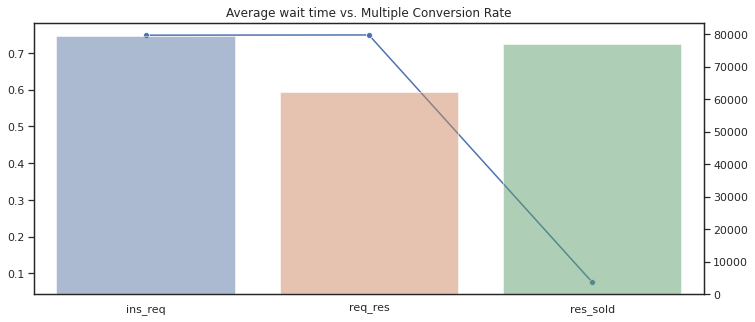

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data = conv_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(x = dt2.columns[-3:]	, y =dt2.describe().mean()[-3:],alpha=0.5, ax=ax2).set(title='Average wait time vs. Multiple Conversion Rate')

## Conversion Rate Redefined


In [ ]:
d = data.copy()
d.iloc[:,1:]= d.iloc[:,1:].apply(pd.to_datetime)
d.dtypes

user_id                                    int64
installation_at                   datetime64[ns]
request_created_at                datetime64[ns]
agent_responded_to_customer_at    datetime64[ns]
customer_sold_at                  datetime64[ns]
dtype: object

In [ ]:
d['duration'] = (d['customer_sold_at'] - d['installation_at']).dt.days
d['period'] = (d['customer_sold_at'] - d['installation_at']).dt.days/90
d.describe()

,user_id,duration,period
count,132296.000000,5739.000000,5739.000000
mean,131166.652952,17.286113,0.192068
std,38236.338992,39.050437,0.433894
min,64922.000000,-226.000000,-2.511111
25%,98046.750000,0.000000,0.000000
50%,131156.500000,3.000000,0.033333
75%,164286.250000,15.000000,0.166667
max,197393.000000,359.000000,3.988889


#### Quarterly

remove all nagative values

In [ ]:
q = """
    SELECT SUM(CASE WHEN duration >0.00 THEN 1 ELSE 0 END) AS pos_time,
           SUM(CASE WHEN duration <0.00 THEN 1 ELSE 0 END) AS nag_time,
           SUM(CASE WHEN duration =0.00 THEN 1 ELSE 0 END) AS immi_res,
           SUM(CASE WHEN duration IS NULL THEN 1 ELSE 0 END ) AS na
    FROM d
"""
w = ps.sqldf(q, locals())

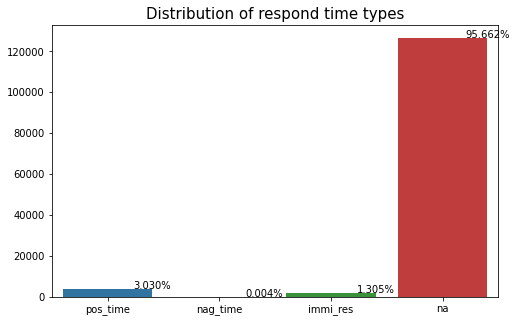

In [ ]:
plt.figure(figsize=(8,5))

ax = sns.barplot(data=w, capsize=.2)
plt.title('Distribution of respond time types', fontsize=15)

for p in ax.patches:
    percentage = '{:.3f}%'.format(100 * p.get_height()/len(d))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [ ]:
q = """
    SELECT *
    FROM d WHERE duration >=0 OR duration is NULL 
"""
d = ps.sqldf(q, locals())

In [ ]:
d.iloc[:,1:5]= d.iloc[:,1:5].apply(pd.to_datetime)
d.dtypes

user_id                                    int64
installation_at                   datetime64[ns]
request_created_at                datetime64[ns]
agent_responded_to_customer_at    datetime64[ns]
customer_sold_at                  datetime64[ns]
duration                                 float64
period                                   float64
dtype: object

In [ ]:
q1 = min(d.installation_at)+ pd.DateOffset(days=90)
q2 = min(d.installation_at)+ pd.DateOffset(days=180)
q3 = min(d.installation_at)+ pd.DateOffset(days=270)
q4 = min(d.installation_at)+ pd.DateOffset(days=360)
q1_ = min(d.installation_at)+ pd.DateOffset(days=450)
print(q1,q2,q3,q4,q1_)

2019-01-08 00:01:00 2019-04-08 00:01:00 2019-07-07 00:01:00 2019-10-05 00:01:00 2020-01-03 00:01:00


In [ ]:
q = """
  SELECT 'Q1' As season,
        COUNT(customer_sold_at) AS sold,
        COUNT(installation_at) AS total
  FROM d
  WHERE installation_at<='2019-01-08' OR customer_sold_at<='2019-01-08' 
UNION 
  SELECT 'Q2' As season,
        COUNT(customer_sold_at) AS sold,
        COUNT(installation_at) AS total
  FROM d
  WHERE (installation_at BETWEEN '2019-01-09' AND '2019-04-08') OR (customer_sold_at BETWEEN '2019-01-09' AND '2019-04-08')  
 UNION 
  SELECT 'Q3' As season,
        COUNT(customer_sold_at) AS sold,
        COUNT(installation_at) AS total
  FROM d
  WHERE  (installation_at BETWEEN '2019-04-09' AND '2019-07-07') OR (customer_sold_at BETWEEN '2019-04-09' AND '2019-07-07') 
  UNION 
  SELECT 'Q4' As season,
        COUNT(customer_sold_at) AS sold,
        COUNT(installation_at) AS total
  FROM d
  WHERE (installation_at BETWEEN '2019-07-08' AND '2019-10-05')  OR (customer_sold_at BETWEEN '2019-07-08' AND '2019-10-05')  
UNION 
 SELECT 'Q5' As season,
        COUNT(customer_sold_at) AS sold,
        COUNT(installation_at) AS total
  FROM d
  WHERE installation_at >='2019-10-06'  OR  customer_sold_at >='2019-10-06'
   
"""
temp = ps.sqldf(q, locals())

In [ ]:
temp['rate'] = np.round(temp['sold']/temp['total'],4)
temp

,season,sold,total,rate
0,Q1,1017,24544,0.0414
1,Q2,1000,20777,0.0481
2,Q3,1239,24995,0.0496
3,Q4,2922,57693,0.0506
4,Q5,358,3709,0.0965


[Text(0.5, 1.0, 'Quarterly Conversion Rate')]

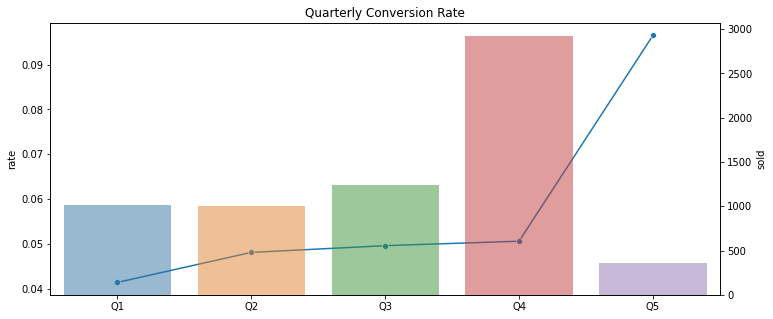

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data = temp['rate'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= temp, x = temp.season	, y = temp.sold,alpha=0.5, ax=ax2).set(title='Quarterly Conversion Rate')

### Feature Generation

In [ ]:
df_time= d.copy().iloc[:,:-1]

In [ ]:
df_time.dtypes

user_id                                    int64
installation_at                   datetime64[ns]
request_created_at                datetime64[ns]
agent_responded_to_customer_at    datetime64[ns]
customer_sold_at                  datetime64[ns]
duration                                 float64
dtype: object

In [ ]:
df_time['year'] = df_time['installation_at'].dt.strftime('%Y')
df_time['year_month'] = df_time['installation_at'].dt.strftime('%Y-%m')
df_time['day_week'] = df_time['installation_at'].dt.strftime('%a')
df_time['day'] = df_time['installation_at'].dt.strftime('%Y-%m-%d')
df_time['hour'] = df_time['installation_at'].dt.strftime('%H')

In [ ]:
df_time.head()

,user_id,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at,duration,year,year_month,day_week,day,hour
0,197393,2019-10-09 23:58:00,2019-10-10 00:03:00,2019-10-10 18:16:00,NaT,NaN,2019,2019-10,Wed,2019-10-09,23
1,197392,2019-10-09 23:57:00,2019-10-10 00:04:00,NaT,NaT,NaN,2019,2019-10,Wed,2019-10-09,23
2,197391,2019-10-09 23:56:00,NaT,NaT,NaT,NaN,2019,2019-10,Wed,2019-10-09,23
3,197390,2019-10-09 23:56:00,2019-10-10 00:11:00,2019-10-10 00:26:00,NaT,NaN,2019,2019-10,Wed,2019-10-09,23
4,197389,2019-10-09 23:56:00,2019-10-09 23:59:00,2019-10-10 23:09:00,NaT,NaN,2019,2019-10,Wed,2019-10-09,23


### Monthly

In [ ]:
q = """
  SELECT year_month, COUNT(user_id) AS total , Count(customer_sold_at) AS conversions,
  SUM( CASE WHEN customer_sold_at IS NULL THEN 1 ELSE 0 END) AS non_conversion
  FROM df_time
  GROUP BY year_month
  HAVING year IS NOT NULL
"""
monthly = ps.sqldf(q, locals())

In [ ]:
monthly = monthly.set_index('year_month')

In [ ]:
monthly

,total,conversions,non_conversion
year_month,,,
2018-10,7069,303,6766
2018-11,9165,400,8765
2018-12,6735,256,6479
2019-01,7389,281,7108
2019-02,6614,250,6364
2019-03,6788,303,6485
2019-04,7243,306,6937
2019-05,8358,406,7952
2019-06,9679,394,9285


In [ ]:
conversion_rate = monthly.conversions/ monthly.total
conversion_rate

year_month
2018-10    0.042863
2018-11    0.043644
2018-12    0.038010
2019-01    0.038030
2019-02    0.037799
2019-03    0.044638
2019-04    0.042248
2019-05    0.048576
2019-06    0.040707
2019-07    0.044622
2019-08    0.047495
2019-09    0.045001
2019-10    0.038832
dtype: float64

[Text(0.5, 1.0, 'Monthly Conversion Rate')]

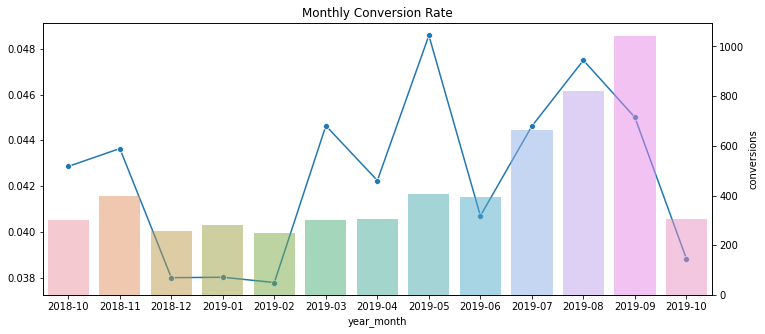

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= monthly, x = monthly.index	, y = monthly.conversions,alpha=0.5, ax=ax2).set(title='Monthly Conversion Rate')

### Daily 

In [ ]:
q = """
  SELECT day, COUNT(user_id) AS total , Count(customer_sold_at) AS conversions,
  SUM( CASE WHEN customer_sold_at IS NULL THEN 1 ELSE 0 END) AS non_conversion
  FROM df_time
  GROUP BY day
  HAVING year IS NOT NULL
"""
daily = ps.sqldf(q, locals())

In [ ]:
daily

,day,total,conversions,non_conversion
0,2018-10-10,426,16,410
1,2018-10-11,350,18,332
2,2018-10-12,220,19,201
3,2018-10-13,95,3,92
4,2018-10-14,117,11,106
...,...,...,...,...
360,2019-10-05,644,26,618
361,2019-10-06,623,18,605
362,2019-10-07,800,30,770
363,2019-10-08,977,28,949


[Text(0.5, 1.0, 'Daily Conversion Rate')]

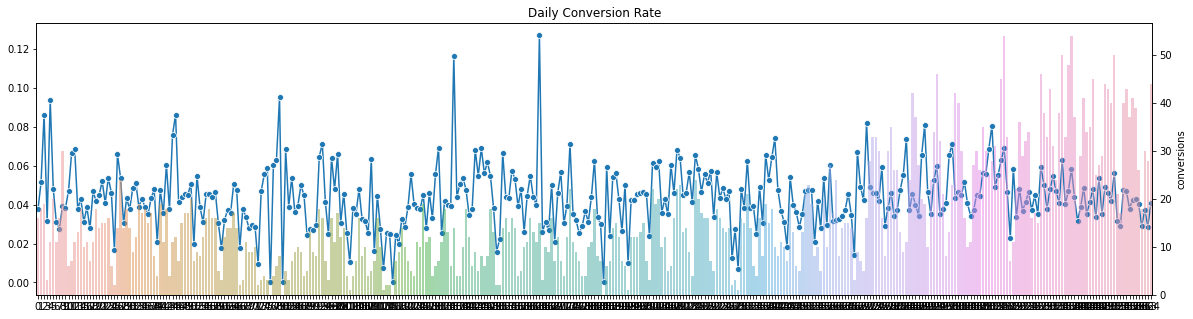

In [ ]:
#daily = daily.set_index('day')
conversion_rate = daily.conversions/ daily.total

fig, ax1 = plt.subplots(figsize=(20,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= daily, x = daily.index	, y = daily.conversions,alpha=0.5, ax=ax2).set(title='Daily Conversion Rate')

### Weekly

In [ ]:
q = """
  SELECT day_week, COUNT(user_id) AS total , Count(customer_sold_at) AS conversions,
  SUM( CASE WHEN customer_sold_at IS NULL THEN 1 ELSE 0 END) AS non_conversion
  FROM df_time
  GROUP BY day_week
  HAVING year IS NOT NULL
"""
weekly = ps.sqldf(q, locals())

In [ ]:
weekly

,day_week,total,conversions,non_conversion
0,Fri,19697,891,18806
1,Mon,20406,843,19563
2,Sat,11119,488,10631
3,Sun,10047,407,9640
4,Thu,23236,982,22254
5,Tue,22672,1018,21654
6,Wed,25108,1105,24003


In [ ]:
weekly = weekly.set_index('day_week')

In [ ]:
conversion_rate = weekly.conversions/ weekly.total

[Text(0.5, 1.0, 'Weekly Conversion Rate')]

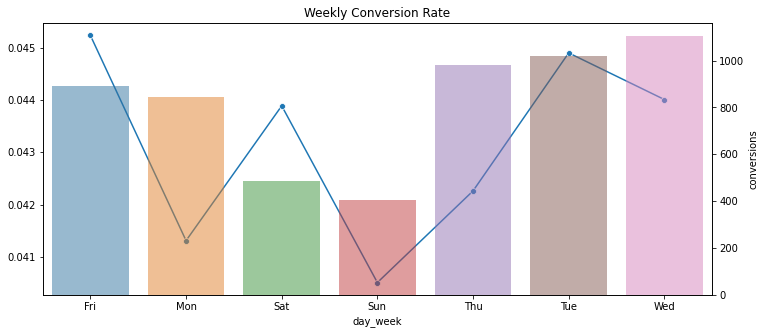

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= weekly, x = weekly.index	, y = weekly.conversions,alpha=0.5, ax=ax2).set(title='Weekly Conversion Rate')

[Text(0.5, 1.0, 'Weekly Total Installs')]

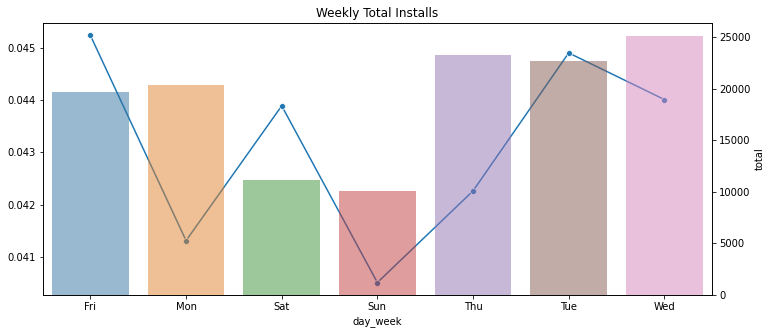

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= weekly, x = weekly.index	, y = weekly.total,alpha=0.5, ax=ax2).set(title='Weekly Total Installs')

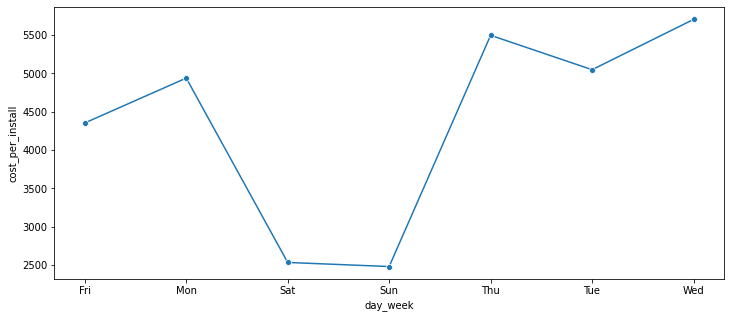

In [ ]:
weekly['converation_rate'] =conversion_rate
weekly['cost_per_install'] = (weekly.total * 0.01) /weekly.converation_rate
weekly[['total','converation_rate','cost_per_install']]

fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =weekly.cost_per_install, marker='o', sort = False, ax=ax1)

### Hourly 

In [ ]:
q = """
  SELECT hour, COUNT(user_id) AS total , Count(customer_sold_at) AS conversions,
  SUM( CASE WHEN customer_sold_at IS NULL THEN 1 ELSE 0 END) AS non_conversion
  FROM df_time
  GROUP BY hour
  HAVING year IS NOT NULL
"""
hourly = ps.sqldf(q, locals())

[Text(0.5, 1.0, 'Hourly Conversion Rate')]

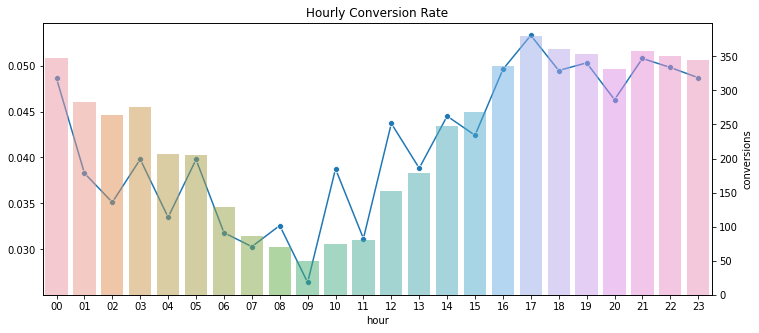

In [ ]:
hourly = hourly.set_index('hour')

conversion_rate = hourly.conversions/ hourly.total

fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= hourly, x = hourly.index	, y = hourly.conversions,alpha=0.5, ax=ax2).set(title='Hourly Conversion Rate')

[Text(0.5, 1.0, 'Hourly Total Installs')]

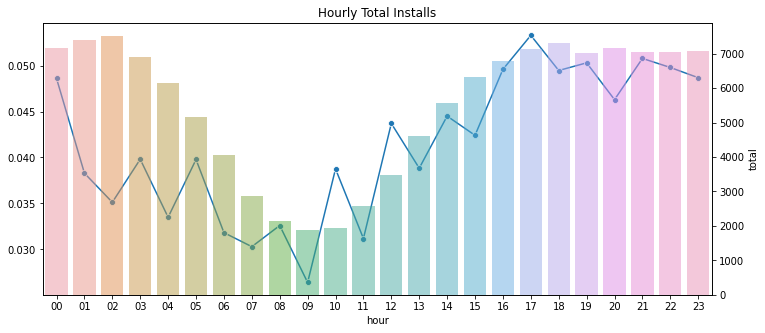

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =conversion_rate, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data= hourly, x = hourly.index	, y = hourly.total,alpha=0.5, ax=ax2).set(title='Hourly Total Installs')

In [ ]:
hourly['converation_rate'] =conversion_rate
hourly['cost_per_install'] = (hourly.total * 0.01) /hourly.converation_rate
hourly[['total','converation_rate','cost_per_install']]

,total,converation_rate,cost_per_install
hour,,,
00,7161,0.048597,1473.560948
01,7390,0.038295,1929.756184
02,7515,0.035130,2139.213068
03,6908,0.039809,1735.289600
04,6149,0.033501,1835.446650
05,5153,0.039783,1295.288244
06,4053,0.031828,1273.396047
07,2871,0.030303,947.430000
08,2147,0.032604,658.515571


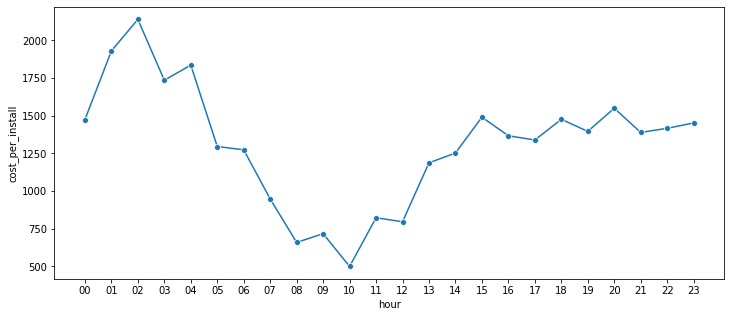

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(data =hourly.cost_per_install, marker='o', sort = False, ax=ax1)

### 90 D interval

In [ ]:
df_m= d.copy()
df_m.dtypes

user_id                                    int64
installation_at                   datetime64[ns]
request_created_at                datetime64[ns]
agent_responded_to_customer_at    datetime64[ns]
customer_sold_at                  datetime64[ns]
duration                                 float64
period                                   float64
dtype: object

In [ ]:
df_m['offset_90'] = df_m['installation_at'] + pd.DateOffset(days=90)
#df_m['day']  = df_m['installation_at'].dt.strftime('%Y-%m-%d')
#df_m['offset_90']  = df_m['offset_90'].dt.strftime('%Y-%m-%d')
df_m['installation_at']= df_m['installation_at'].dt.date
df_m['offset_90']= df_m['offset_90'].dt.date

df_m.head()

,user_id,installation_at,request_created_at,agent_responded_to_customer_at,customer_sold_at,duration,period,offset_90
0,197393,2019-10-09,2019-10-10 00:03:00,2019-10-10 18:16:00,NaT,NaN,NaN,2020-01-07
1,197392,2019-10-09,2019-10-10 00:04:00,NaT,NaT,NaN,NaN,2020-01-07
2,197391,2019-10-09,NaT,NaT,NaT,NaN,NaN,2020-01-07
3,197390,2019-10-09,2019-10-10 00:11:00,2019-10-10 00:26:00,NaT,NaN,NaN,2020-01-07
4,197389,2019-10-09,2019-10-09 23:59:00,2019-10-10 23:09:00,NaT,NaN,NaN,2020-01-07


In [ ]:
df_time = df_m[['installation_at','customer_sold_at']].apply(pd.to_datetime)
df_time.dtypes

installation_at     datetime64[ns]
customer_sold_at    datetime64[ns]
dtype: object

In [ ]:
df_time.installation_at.iloc[1]

Timestamp('2019-10-09 00:00:00')

In [ ]:
df_new = pd.DataFrame(columns=['total','sold'])
df_new

,total,sold


In [ ]:
q = """SELECT DISTINCT installation_at, offset_90
      FROM df_m 
      WHERE installation_at IS NOT NULL
"""
interv = ps.sqldf(q,locals())

In [ ]:
interv=interv.apply(pd.to_datetime)
interv.dtypes

installation_at    datetime64[ns]
offset_90          datetime64[ns]
dtype: object

In [ ]:
total = []
sold =[]
for i in range(0,len(df_time)):
  user =0
  conv= 0
  for j in range(0,len(interv)):
    if df_time.installation_at.iloc[i] >= interv.iloc[j].values[0] and df_time.installation_at.iloc[i] <= interv.iloc[j].values[1]:
      user += 1
    if df_time.customer_sold_at.iloc[i] >= interv.iloc[j].values[0] and df_time.customer_sold_at.iloc[i] <= interv.iloc[j].values[1]:
      conv +=1
  total.append(user)
  sold.append(conv)

## Time Series Forcasting Model

In [ ]:
daily['conversion_reate'] = daily.conversions/daily.total
daily =daily.reset_index()

In [ ]:
daily.dtypes

### ARIMA

In [ ]:
pip install statsmodels

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
daily.dtypes

index                 int64
day                  object
total                 int64
conversions           int64
non_conversion        int64
conversion_reate    float64
dtype: object

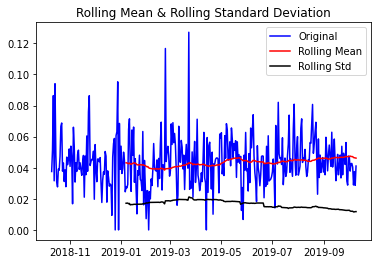

In [ ]:
rolling_mean = df.rolling(window = 90).mean()
rolling_std = df.rolling(window = 90).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Plot the rolling mean and rolling standard deviation.he rolling mean and rolling standard deviation are almost flat with time. Therefore, we can conclude that the time series is  stationary.


In [ ]:
# split into train and test sets
X = daily.conversion_reate
size = int(len(X)*0.66)
train, test = X[0:size], X[size:len(X)]

In [ ]:
# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.conversion_reate   No. Observations:                  363
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 985.324
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sat, 26 Feb 2022   AIC                          -1954.647
Time:                        10:31:24   BIC                          -1923.492
Sample:                             1   HQIC                         -1942.263
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     9.011e-06   9.94e-06      0.906      0.365   -1.05e-05    2.85e-05
ar.L1.D.conversion_reate     0.0661      0.052      1.259      0.209      -0.037       0.

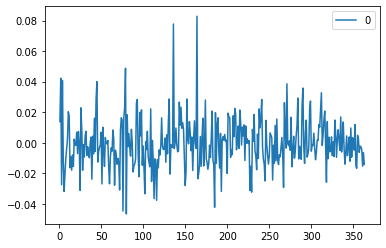

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

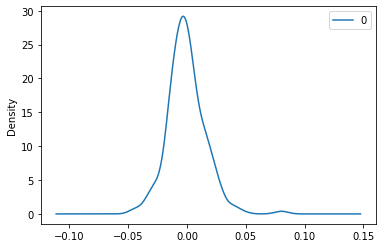

In [ ]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

suggesting the errors are Gaussian, but may not be centered on zero.

In [ ]:
# summary stats of residuals
print(residuals.describe())

                0
count  363.000000
mean    -0.000559
std      0.016097
min     -0.046608
25%     -0.010173
50%     -0.001821
75%      0.007482
max      0.082830


In [ ]:
df= daily['conversion_reate']
df.index =daily['day']
df

day
2018-10-10    0.037559
2018-10-11    0.051429
2018-10-12    0.086364
2018-10-13    0.031579
2018-10-14    0.094017
                ...   
2019-10-05    0.040373
2019-10-06    0.028892
2019-10-07    0.037500
2019-10-08    0.028659
2019-10-09    0.041083
Name: conversion_reate, Length: 365, dtype: float64

In [ ]:
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

In [ ]:
X = daily.conversion_reate
size = int(len(X)*0.66)
train, test = X[0:size], X[size:len(X)]

In [ ]:
type(test)

pandas.core.series.Series

In [ ]:
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f's % rmse)


Test RMSE: 0.014


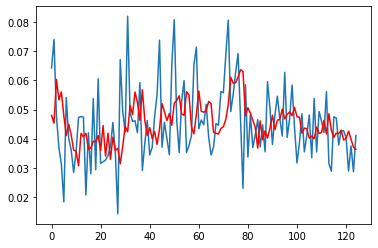

In [ ]:
# plot forecasts against actual outcomes
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

The model could use further tuning of the p, d, and maybe even the q parameters.

### Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
daily['day']= pd.to_datetime(daily['day'])

Input Features x and y 

In [ ]:
x= daily.iloc[:,:-1]
y= daily.iloc[:,-1:]

creating dataset for prophet

In [ ]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(x["day"])
train_dataset['y']=y
train_dataset.tail(2)

,ds,y
363,2019-10-08,0.028659
364,2019-10-09,0.041083


Creating and fitting the Prophet model with default values

In [ ]:
m = Prophet()
m.fit(train_dataset)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting the values for the future

In [ ]:
future= m.make_future_dataframe(periods=360)
future.tail(2)

,ds
723,2020-10-02
724,2020-10-03


Total number of rows in original dataset was 723 and we see that the future data frame that we created for prediction contains historical dates as well as additional 360 dates.

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
720,2020-09-29,0.049677,0.029526,0.069329
721,2020-09-30,0.051282,0.030935,0.072682
722,2020-10-01,0.047720,0.027732,0.067538
723,2020-10-02,0.051783,0.030721,0.072631
724,2020-10-03,0.050801,0.030440,0.070168


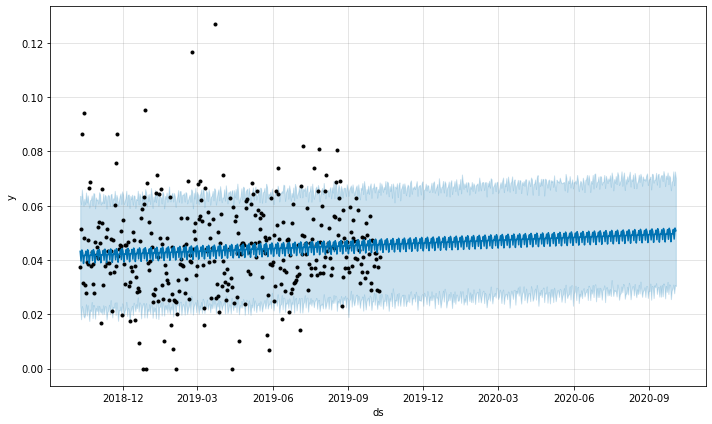

In [ ]:
fig1 = m.plot(forecast)

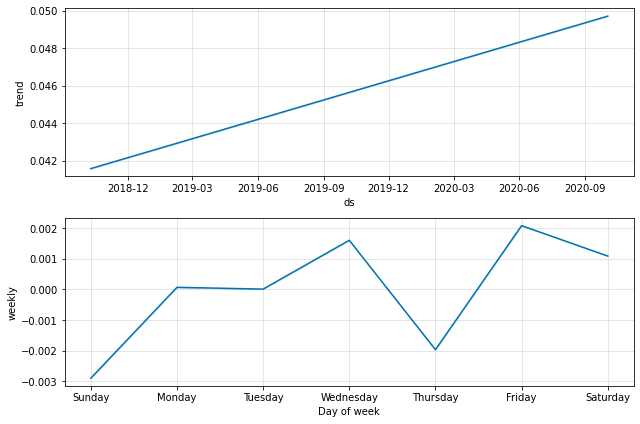

In [ ]:
fig2 = m.plot_components(forecast)

#plot the trend and seasonality, components of the forecast.

In [ ]:
pip install prophet

In [ ]:
from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


### Evaluation

In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='90 days', period='90 days', horizon = '90 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2019-01-12 00:00:00 and 2019-07-11 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
df_cv


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-13,0.041050,0.018156,0.061938,0.024793,2019-01-12
1,2019-01-14,0.040790,0.020674,0.062174,0.064257,2019-01-12
2,2019-01-15,0.033538,0.010950,0.054812,0.048035,2019-01-12
3,2019-01-16,0.036993,0.017779,0.057921,0.066148,2019-01-12
4,2019-01-17,0.040369,0.020195,0.061590,0.030612,2019-01-12
...,...,...,...,...,...,...
265,2019-10-05,0.044605,0.023481,0.065788,0.040373,2019-07-11
266,2019-10-06,0.038960,0.017079,0.061035,0.028892,2019-07-11
267,2019-10-07,0.045126,0.023165,0.068378,0.037500,2019-07-11
268,2019-10-08,0.042627,0.019757,0.063896,0.028659,2019-07-11


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,9 days,0.000296,0.017196,0.013877,0.301802,0.401255,0.814815
1,10 days,0.000259,0.016098,0.012936,0.295685,0.332457,0.814815
2,11 days,0.000222,0.014902,0.011618,0.240986,0.310593,0.851852
3,12 days,0.000201,0.014187,0.010553,0.194977,0.279382,0.851852
4,13 days,0.000171,0.013085,0.009736,0.188112,0.266865,0.888889


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



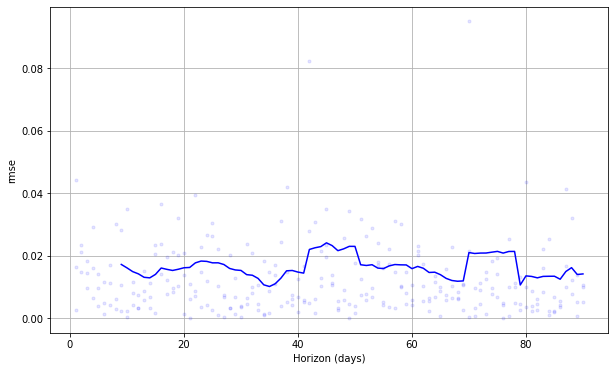

In [ ]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='rmse')